# COMP9418 Assignment 2

## *Tasks TODO*
- parameter initialization
- mean negative log probability
- sample predictions.txt generator


In [373]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import hmmlearn
import sklearn
from hmmlearn.hmm import GaussianHMM, GMMHMM
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
%matplotlib inline

In [374]:
# make sure it's version 0.2.1 (install from github, not pip)
# pip install git+https://github.com/hmmlearn/hmmlearn.git
hmmlearn.__version__

'0.2.1'

In [375]:
sklearn.__version__

'0.19.0'

In [376]:
seed = 1234
rng = np.random.RandomState(seed)

In [377]:
# Load the data
trainData = sio.loadmat('./trajectories_train.mat')
testData = sio.loadmat('./trajectories_xtest.mat')

In [378]:
# Clean up the data
xtrain = trainData['xtrain'].reshape((-1, ))
ytrain = trainData['ytrain'].reshape((-1, ))
kf = StratifiedKFold(n_splits = 3, random_state=rng)
xtest = testData['xtest'].reshape((-1, ))
key = trainData['key']
key = [item[0] for item in key.reshape((-1, ))]

In [379]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print([sum(yval == i) for i in np.unique(ytrain)])

(1429L,)
(1429L,)
(1429L,)
[31, 25, 24, 18, 28, 20, 17, 22, 8, 11, 24, 23, 15, 18, 22, 18, 34, 17, 21, 33]


# Data visualization

In [380]:
idx = 50

In [381]:
x = xtrain[idx]
y = ytrain[idx]

In [382]:
def plot_char(data, label):
    start_x = 0
    start_y = 0
    plt.plot(start_x, start_y, 'ro')
    for vel_h, vel_v, alpha in zip(data[0,], data[1, ], 1/(1 + np.exp(-data[2, ]/np.sum(data[1, ])))):
        start_x = start_x + vel_h
        start_y = start_y + vel_v
        plt.plot(start_x, start_y,'bo', alpha = alpha)
    plt.title('Character ' + key[label-1])
    plt.show()

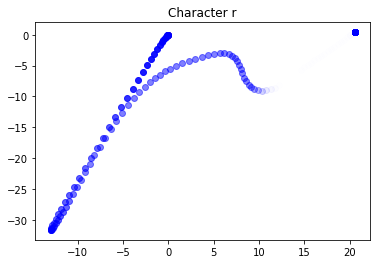

In [383]:
plot_char(x, y)

# Data Cleaning and Preparation

In [384]:
xtrain = np.asarray([seq.T for seq in xtrain])
xtest = np.asarray([seq.T for seq in xtest])

In [385]:
print(xtrain.shape)
print(xtest.shape)

(1429L,)
(1429L,)


In [386]:
lengths_train = list(map(lambda x: x.shape[0], xtrain))
lengths_test = list(map(lambda x: x.shape[0], xtest))

In [387]:
label_enc = LabelEncoder().fit(ytrain)
label_enc.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=uint8)

# Generative Classifier

In [388]:
def log_likelihood(hmm, sequence):

    logprob_frame = hmm._compute_log_likelihood(sequence)
    logprob_sequence, _ =  hmm._do_forward_pass(logprob_frame)

    return logprob_sequence

def log_likelihoods(hmm, sequences):

    ll = lambda seq: log_likelihood(hmm, seq)

    return np.fromiter(map(ll, sequences), dtype='float64')

def log_likelihoods_cond(cond_hmms, sequences):

    ll = lambda hmm: log_likelihoods(hmm, sequences)

    return np.vstack(map(ll, cond_hmms))

In [389]:
class GenerativeClassifierHMM(BaseEstimator, ClassifierMixin):

    def __init__(self, hmm=GaussianHMM()):

        self.hmm = hmm
        self.class_cond_hmms_ = []

    def fit(self, sequences, labels):

        class_counts = np.bincount(labels).astype(np.float)
        self.logprior = np.log(class_counts / np.sum(class_counts))

        for c in range(np.max(labels)+1):

            sequences_c = sequences[labels == c]

            X_c = np.vstack(sequences_c)
            lengths_c = list(map(len, sequences_c))
            
            class_cond_hmm = clone(self.hmm, safe=True)
            class_cond_hmm.fit(X_c, lengths=lengths_c)

            self.class_cond_hmms_.append(class_cond_hmm)

        return self
    
    def predict(self, sequences):
        # 20 x N matrix
        log_likelihood_ = log_likelihoods_cond(self.class_cond_hmms_, sequences)

        log_post_unnorm = log_likelihood_ + self.logprior.reshape(-1, 1)

        return np.argmax(log_post_unnorm, axis=0)
    
    def generateSample(self, mClass, length):
        sel_hmm = self.class_cond_hmms_[mClass]
        x, _ = sel_hmm.sample(length)
        return x

# Guassian HMM

In [390]:
# Parameters
n_states = 10

# initial guess for EM
pi0 = np.eye(1, n_states)[0] # start probability
pi0

# initial guess for EM
# transition matrix
trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
trans0 /= trans0.sum(axis=1).reshape(-1, 1)
trans0

array([[ 0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.5,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.5,  0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]])

In [391]:
hmm = GaussianHMM(n_components=n_states, 
                  init_params='mc',
                  n_iter=10,
                  random_state=seed)
hmm.startprob_ = pi0
hmm.transmat_  = trans0

In [392]:
# due to https://github.com/hmmlearn/hmmlearn/issues/158 and 
# https://github.com/hmmlearn/hmmlearn/issues/175
# the fitting process is going to give a LOT of warnings
# so we hide them in this notebook
import warnings
warnings.filterwarnings('ignore')

In [393]:
hmm_classifier = GenerativeClassifierHMM(hmm)

train_index, test_index = list(kf.split(xtrain, ytrain))[0]

hmm_classifier.fit(xtrain[train_index], 
                   label_enc.transform(ytrain[train_index]))

GenerativeClassifierHMM(hmm=GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='mc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=10, n_iter=10, params='stmc',
      random_state=1234, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False))

In [394]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[test_index]))

In [396]:
print('Accuracy', (y_val_pred == ytrain[test_index]).mean())

('Accuracy', 0.90248962655601661)


Generate a random sample from the gmm for a certain class

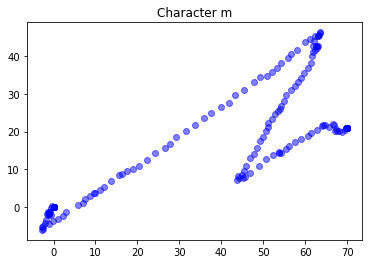

In [428]:
myClass = [9]
x = hmm_classifier.generateSample(label_enc.transform(myClass), 200)
plot_char(x.T, myClass[0])

### Basic Cross Validation

In [212]:
cv1_results = {}
for k in range(5, 31):
    pi0 = np.eye(1, k)[0]
    trans0 = np.diag(np.ones(k)) + np.diag(np.ones(k-1), 1)
    trans0 /= trans0.sum(axis=1).reshape(-1, 1)
    hmm = GaussianHMM(n_components=k, 
                      init_params='mc',
                      n_iter=10,
                      random_state=seed)
    correct = 0.0
    for train_index, test_index in kf.split(xtrain, ytrain):
        hmm.startprob_ = pi0
        hmm.transmat_  = trans0
        hmm_classifier = GenerativeClassifierHMM(hmm)

        hmm_classifier.fit(xtrain[train_index], label_enc.transform(ytrain[train_index]))
        y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xtrain[test_index]))
        correct += np.sum(y_val_pred == ytrain[test_index])
    accuracy = correct/xtrain.shape[0]
    cv1_results[k] = accuracy
    print('Accuracy', k, accuracy)

('Accuracy', 5, 0.7599720083974808)
('Accuracy', 6, 0.7935619314205739)
('Accuracy', 7, 0.8439468159552135)
('Accuracy', 8, 0.8684394681595521)
('Accuracy', 9, 0.8922323303009098)
('Accuracy', 10, 0.8992302309307207)
('Accuracy', 11, 0.9027291812456263)
('Accuracy', 12, 0.8985304408677397)
('Accuracy', 13, 0.8978306508047585)
('Accuracy', 14, 0.9090272918124562)
('Accuracy', 15, 0.9104268719384184)
('Accuracy', 16, 0.9153254023792862)
('Accuracy', 17, 0.907627711686494)
('Accuracy', 18, 0.9104268719384184)
('Accuracy', 19, 0.9167249825052485)


KeyboardInterrupt: 

# Gaussian HMM with different states per class

In [106]:
class GenerativeClassifierHMMCV(BaseEstimator, ClassifierMixin):

    def __init__(self, k=range(3,9)):
        self.class_cond_hmms_ = []
        self.k = k

    def fit(self, sequences, labels):
        kf = KFold(n_splits = 3)
        class_counts = np.bincount(labels).astype(np.float)
        self.logprior = np.log(class_counts / np.sum(class_counts))

        for c in range(np.max(labels)+1):
            sequences_c = sequences[labels == c]
            sequences_not_c = sequences[labels != c]

            lengths_c = np.array(list(map(len, sequences_c)))
            log_likels = {}
            for n_states in self.k: 
                pi0 = np.eye(1, n_states)[0] # start probability

                trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
                trans0 /= trans0.sum(axis=1).reshape(-1, 1)
                
                hmm = GaussianHMM(n_components=n_states, 
                  init_params='mc',
                  n_iter=10,
                  random_state=seed)
                
                log_likel = 0
                for train_index, test_index in kf.split(sequences_c):
                    hmm.startprob_ = pi0
                    hmm.transmat_  = trans0
                    
                    X_c = np.vstack(sequences_c[train_index])
                    
                    hmm.fit(X_c, lengths=lengths_c[train_index])
                    log_likel += np.sum(log_likelihoods(hmm, sequences_c[test_index]))
                    
                log_likels[n_states] = log_likel
                print('Label ' + str(c) + ' for states ' + str(n_states) + ': Log in class ' + 
                      str(log_likel) + 
                      '\nmax log off class ' + str(np.max(log_likelihoods(hmm, sequences_not_c)))
                     + '\n min log in class ' + str(np.min(log_likelihoods(hmm, sequences_c))))
                
#             self.class_cond_hmms_.append(class_cond_hmm)

        return self
    
    def predict(self, sequences):
        # 20 x N matrix
        log_likelihood_ = log_likelihoods_cond(self.class_cond_hmms_, sequences)

        log_post_unnorm = log_likelihood_ + self.logprior.reshape(-1, 1)

        return np.argmax(log_post_unnorm, axis=0)

In [ ]:
hmm_classifier_CV = GenerativeClassifierHMMCV(k = range(15, 31))
hmm_classifier_CV.fit(xtrain, 
                   label_enc.transform(ytrain))

# Gaussian Mixture HMM

**Note**:
I was getting some results (70%) with these parameters when I was on version 0.2.0 but after updating to the latest
version (0.2.1), GMMHMM hasn't been great and it's taking too long to run. There are some open issues on their Github which seem to suggest GMMHMM is a bit buggy atm.

In [97]:
# Parameters
n_states = 3
n_mix = 10
# initial guess for EM
pi0 = np.eye(1, n_states)[0] # start probability
pi0

# initial guess for EM
# transition matrix
trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
trans0 /= trans0.sum(axis=1).reshape(-1, 1)
trans0

array([[ 0.5,  0.5,  0. ],
       [ 0. ,  0.5,  0.5],
       [ 0. ,  0. ,  1. ]])

In [102]:
gmmhmm = GMMHMM(n_components=n_states, 
                n_mix=n_mix,
                covariance_type='diag',
                init_params='mc',
                n_iter=3,
                random_state=rng)
gmmhmm.startprob_ = pi0
gmmhmm.transmat_  = trans0

In [103]:
hmm_classifier = GenerativeClassifierHMM(gmmhmm)
hmm_classifier.fit(xtrain, label_enc.transform(ytrain))

GenerativeClassifierHMM(hmm=GMMHMM(algorithm='viterbi', covariance_type='diag', covars_prior=None,
    covars_weight=None, init_params='mc', means_prior=0.0,
    means_weight=0.0, min_covar=0.001, n_components=3, n_iter=3, n_mix=10,
    params='stmcw',
    random_state=<mtrand.RandomState object at 0x000000000A48A3A8>,
    startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False,
    weights_prior=1.0))

In [104]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xval))

(20L, 429L)
(20L,)


In [105]:
print('Accuracy', (y_val_pred == yval).mean())

('Accuracy', 0.38694638694638694)
